In [ ]:
#importing all the required library for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions

from io import StringIO
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#mount the google colab with google drive content:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 
folder = os.path.join('/content/drive/My Drive/kaggle')

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/kaggle/Corona_NLP_train.csv',encoding='latin1')
test=pd.read_csv('/content/drive/MyDrive/kaggle/Corona_NLP_test.csv',encoding='latin1')


In [ ]:
train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)

In [ ]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
train.shape

(41157, 6)

In [ ]:
# All tweets came only from March and April month of 2020.
train.TweetAt.value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

In [ ]:
# There are 12220 unique locations from where the tweets came.
train['Location'].value_counts()

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

In [ ]:
# There are 5 unique sentiment types in our dataset
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
train.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", train.shape)


 Shape of dataframe after dropping duplicates:  (41157, 6)


In [ ]:
#Null values

null= train.isnull().sum().sort_values(ascending=False)
total =train.shape[0]
percent_missing= (train.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)

Null Values in each column:
      column name  Total missing  Percent missing
0       Location           8590         0.208713
1       UserName              0         0.000000
2     ScreenName              0         0.000000
3        TweetAt              0         0.000000
4  OriginalTweet              0         0.000000
5      Sentiment              0         0.000000


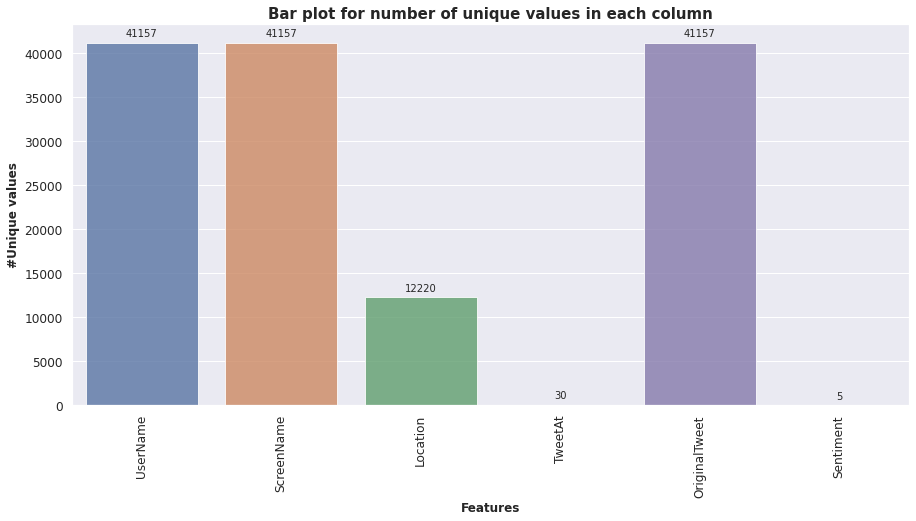

In [ ]:
#Unique Values In Each Feature Coulmn
unique_df = pd.DataFrame()
unique_df['Features'] = train.columns
unique=[]
for i in train.columns:
    unique.append(train[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Top 10 locations of tweet
Top_Location_Of_tweet= train['Location'].value_counts().head(10)

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')
Top_Location_Of_tweet.head(10)

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


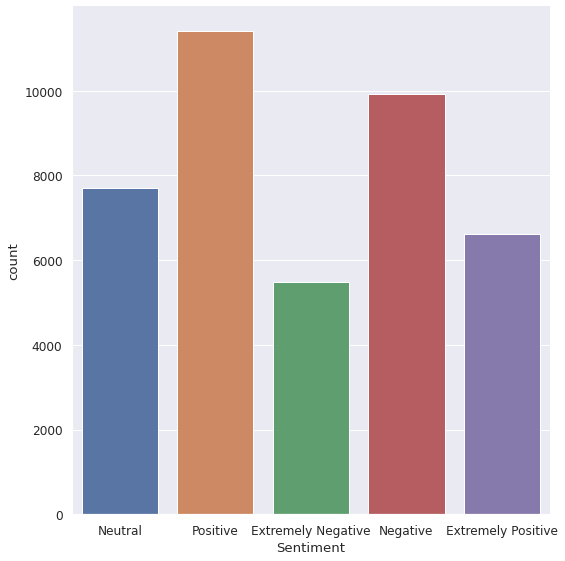

In [ ]:
#Sentiments Countplot
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=train, kind="count", height=8)

In [ ]:
train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

In [ ]:
#Data preprocessing
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
train['text_new']=train['text'].apply(lambda x:remove_urls(x))
test['text_new']=test['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
train['text']=train['text_new'].apply(lambda x:remove_html(x))
test['text']=test['text_new'].apply(lambda x:remove_html(x))

# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
train['text_new']=train['text'].apply(lambda x:lower(x))
test['text_new']=test['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
train['text']=train['text_new'].apply(lambda x:remove_num(x))
test['text']=test['text_new'].apply(lambda x:remove_num(x))

#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
train['text_new']=train['text'].apply(lambda x:punct_remove(x))
test['text_new']=test['text'].apply(lambda x:punct_remove(x))


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
train['text']=train['text_new'].apply(lambda x:remove_stopwords(x))
test['text']=test['text_new'].apply(lambda x:remove_stopwords(x))

#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
train['text_new']=train['text'].apply(lambda x:remove_mention(x))
test['text_new']=test['text'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
train['text']=train['text_new'].apply(lambda x:remove_hash(x))
test['text']=test['text_new'].apply(lambda x:remove_hash(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
train['text_new']=train['text'].apply(lambda x:remove_space(x))
test['text_new']=test['text'].apply(lambda x:remove_space(x))
test = test.drop(columns=['text_new'])
train = train.drop(columns=['text_new'])

In [ ]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil_gahan chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak im paranoi...


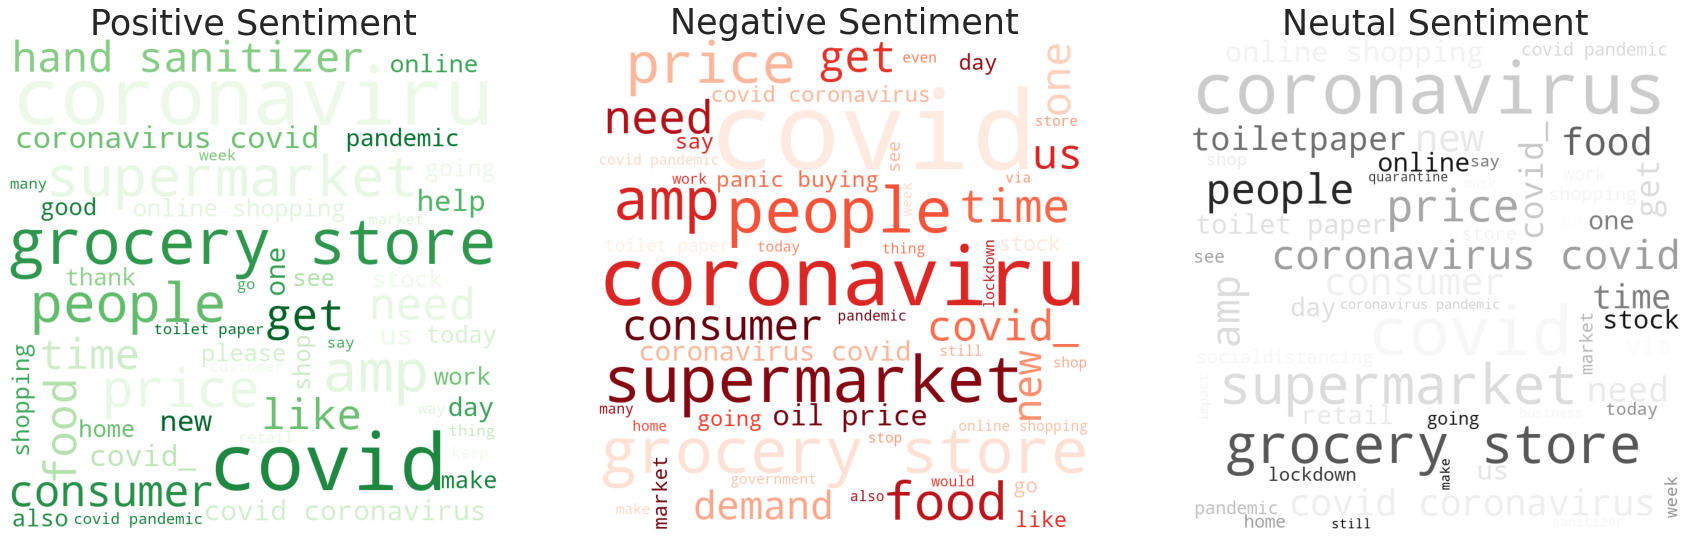

In [ ]:
# create text from just normal tweets
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
train_pos =train[train["Sentiment"]=="Positive"]
train_neg =train[train["Sentiment"]=="Negative"]
train_neu =train[train["Sentiment"]=="Neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in train_pos.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10,max_words=50).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in train_neg.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "



wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10,max_words=50).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in train_neu.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10,max_words=50).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

In [ ]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [ ]:
# extracting hashtags from non racist/sexist tweets
HT_Extremely_Positive = hashtag_extract(train['OriginalTweet'][train['Sentiment'] == 'Extremely Positive'])
HT_Positive = hashtag_extract(train['OriginalTweet'][train['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(train['OriginalTweet'][train['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(train['OriginalTweet'][train['Sentiment'] == 'Negative'])
HT_Extremely_Negative = hashtag_extract(train['OriginalTweet'][train['Sentiment'] == 'Extremely Negative'])



# unnesting list
HT_Extremely_Positive = sum(HT_Extremely_Positive, [])
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])
HT_Extremely_Negative = sum(HT_Extremely_Negative,[])

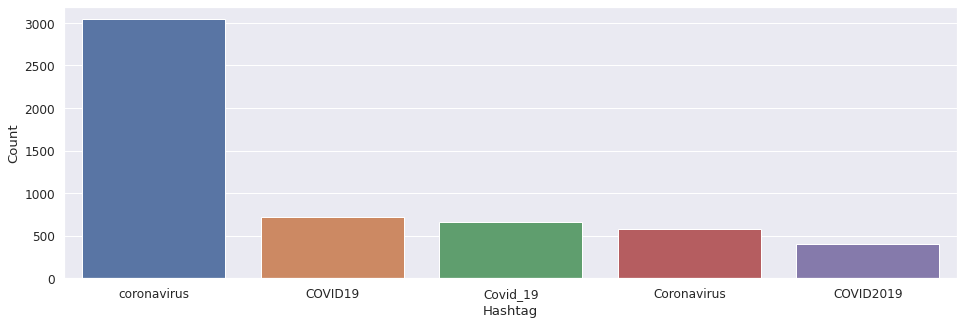

In [ ]:
# making frequency distribution top 10 Negative hashtags
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 5)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

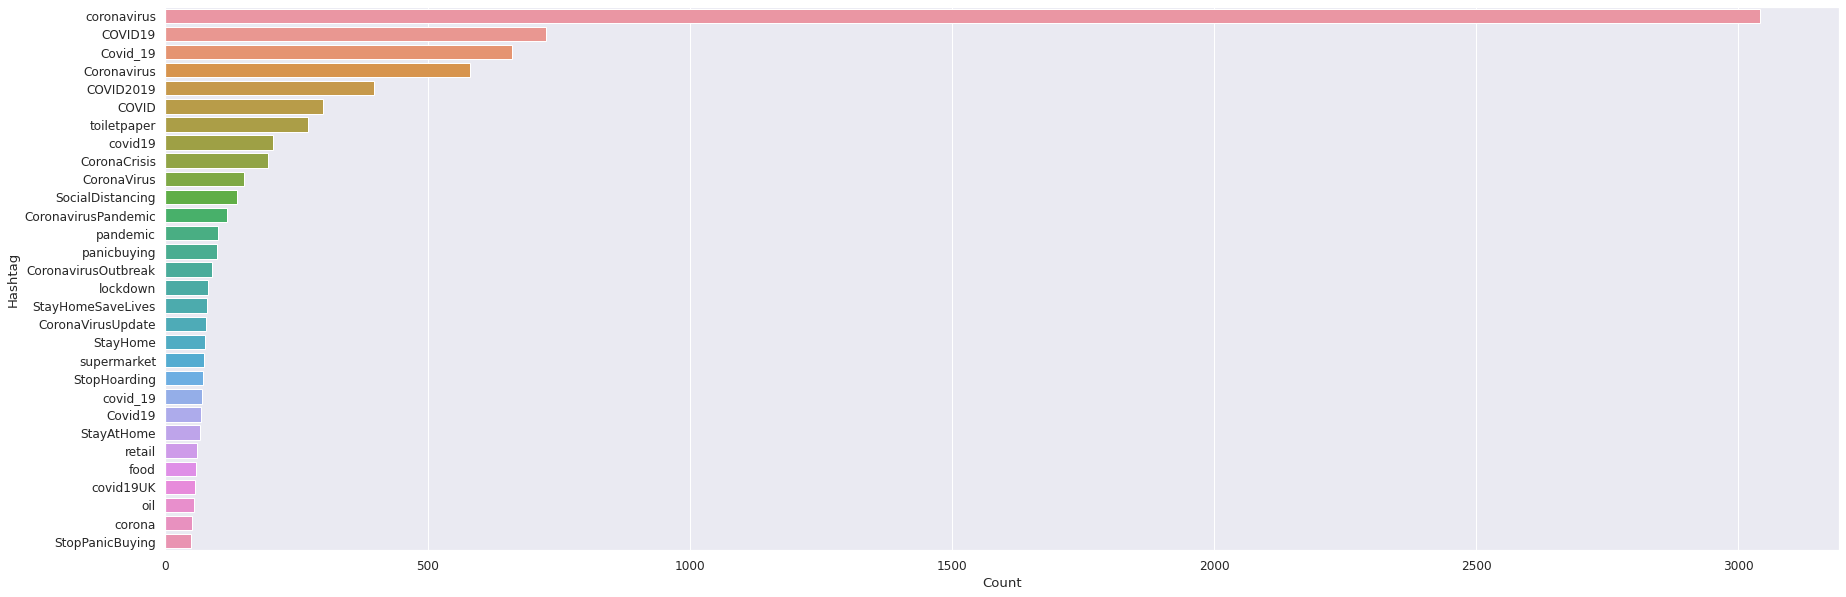

In [ ]:
#lets check with more top 15 as some word where looks similar in top 5
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 30)

plt.figure(figsize = (30,10))
ax = sns.barplot(data =d, y = 'Hashtag', x = 'Count')
plt.show()

In [ ]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil_gahan chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak im paranoi...


In [ ]:
# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

train['label']=train['Sentiment'].apply(lambda x:classes_def(x))
test['label']=test['Sentiment'].apply(lambda x:classes_def(x))


train.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

In [ ]:
X_train = train["text"].tolist()
y_train = train["label"].tolist()
X_test=test["text"].tolist()
y_test=test["label"].tolist()


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                    
                        stop_words='english')

# We transform each text into a vector
features = tfidf.fit_transform(train.text).toarray()

labels = train.label

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 41157 tweets is represented by 10615 features (TF-IDF score of unigrams and bigrams)


In [ ]:
#lets use three machine learning model to check best among them for this classification problem with cross validation method:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.784411,0.004532
MultinomialNB,0.659791,0.003452
RandomForestClassifier,0.470029,0.003683


In [ ]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(train)
X_train_vect = Tfidf_vect.transform(X_train)
X_train_vect = Tfidf_vect.transform(X_test)

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(X_train)
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [ ]:
print(Tfidf_vect.vocabulary_)

{'advice': 151, 'talk': 9260, 'neighbours': 6199, 'family': 3479, 'exchange': 3333, 'phone': 6819, 'numbers': 6337, 'create': 2224, 'contact': 1885, 'list': 5447, 'schools': 8185, 'employer': 3128, 'chemist': 1490, 'gp': 4105, 'set': 8338, 'online': 6440, 'shopping': 8448, 'accounts': 63, 'adequate': 115, 'supplies': 9138, 'regular': 7660, 'meds': 5808, 'order': 6490, 'coronavirus': 2014, 'australia': 617, 'woolworths': 10415, 'give': 4013, 'elderly': 3070, 'disabled': 2686, 'dedicated': 2454, 'hours': 4520, 'amid': 323, 'covid': 2139, 'outbreak': 6523, 'food': 3707, 'stock': 8948, 'one': 6434, 'empty': 3132, 'please': 6921, 'dont': 2831, 'panic': 6624, 'enough': 3181, 'everyone': 3298, 'take': 9252, 'need': 6180, 'stay': 8886, 'calm': 1232, 'safe': 8049, 'covid_': 2140, 'confinement': 1811, 'ready': 7539, 'go': 4043, 'supermarket': 9124, 'im': 4648, 'paranoid': 6652, 'serious': 8326, 'thing': 9433, 'causes': 1371, 'shortage': 8456, 'stayathome': 8887, 'news': 6220, 'first': 3635, 'con

In [ ]:
print(X_train_vect)

  (97, 1)	1.0
  (168, 5)	1.0
  (548, 4)	1.0
  (1060, 1)	1.0
  (1104, 1)	1.0
  (1160, 1)	1.0
  (1378, 4)	1.0
  (2068, 4)	1.0
  (2451, 1)	1.0
  (2531, 1)	1.0
  (2584, 1)	1.0
  (2816, 1)	1.0
  (2887, 1)	1.0
  (3435, 1)	1.0


In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
Linear_SVC=LinearSVC()
Linear_SVC.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_Linear_SVC = Linear_SVC.predict(Test_X_Tfidf)
predictions_Linear_SVC

array(['0', '2', '2', ..., '1', '0', '2'], dtype='<U1')